<a href="https://colab.research.google.com/github/Rabbit-Hu/Hung-yi-Lee-ML20/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

Downloading...
From: https://drive.google.com/uc?id=19CzXudqN58R3D-1G8KeFWk8UDQwlb8is
To: /content/food-11.zip
1.16GB [00:08, 140MB/s]
Archive:  food-11.zip
replace food-11/testing/0071.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

# Load the data

There are 11 classes of pictures of food. The file names are like "[category]_[number].jpg".

In [4]:
def read_files(path, labeled):
    img_dir = sorted(os.listdir(path))
    x = np.zeros([len(img_dir), 128, 128, 3], dtype=np.uint8)
    y = np.zeros([len(img_dir)], dtype=np.uint8)
    for i, file_name in enumerate(img_dir):
        img = cv2.imread(os.path.join(path, file_name))
        x[i, :, :] = cv2.resize(img, (128, 128))
        if labeled:
            y[i] = int(file_name.split('_')[0])
    return (x, y) if labeled else x

In [5]:
workspace_dir = './food-11'
train_x, train_y = read_files(os.path.join(workspace_dir, 'training'), True)
val_x, val_y = read_files(os.path.join(workspace_dir, 'validation'), True)
test_x = read_files(os.path.join(workspace_dir, 'testing'), False)

Category: 0


(49152, (128, 128, 3))

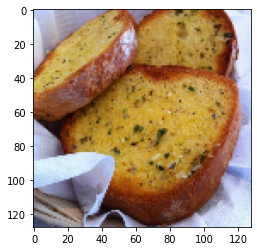

In [6]:
plt.imshow((train_x[0]/256)[:,:,(2,1,0)]) # Check if loading is successful
print('Category: {}'.format(train_y[0]))
train_x[0].size, train_x[0].shape

# Dataset

In [7]:
# training 時做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [8]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

## The model

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dimensions[3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), # 64*128*128
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2, 0), # 64*64*64
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, 1, 1), # 128*64*64
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2, 0), # 128*32*32
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, 1, 1), # 256*32*32
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2, 0), # 256*16*16
            nn.ReLU(),

            nn.Conv2d(256, 512, 3, 1, 1), # 512*16*16
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, 0), # 512*8*8
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1), # 512*8*8
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, 0), # 512*4*4
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 11),
        )
    def forward(self, X):
        out = self.cnn(X)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

## Training



In [10]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_num = 30

for epoch in range(epoch_num):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epoch_num, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), \
             val_acc/val_set.__len__(), val_loss/val_set.__len__()))

[001/030] 42.05 sec(s) Train Acc: 0.220860 Loss: 0.018326 | Val Acc: 0.269388 loss: 0.015916
[002/030] 41.98 sec(s) Train Acc: 0.313501 Loss: 0.015343 | Val Acc: 0.310496 loss: 0.015290
[003/030] 42.31 sec(s) Train Acc: 0.371376 Loss: 0.014207 | Val Acc: 0.378134 loss: 0.014291
[004/030] 42.42 sec(s) Train Acc: 0.412122 Loss: 0.013328 | Val Acc: 0.333819 loss: 0.015660
[005/030] 42.13 sec(s) Train Acc: 0.463612 Loss: 0.012170 | Val Acc: 0.362682 loss: 0.014871
[006/030] 42.17 sec(s) Train Acc: 0.490574 Loss: 0.011549 | Val Acc: 0.425073 loss: 0.013209
[007/030] 42.49 sec(s) Train Acc: 0.525745 Loss: 0.010785 | Val Acc: 0.401458 loss: 0.014132
[008/030] 42.12 sec(s) Train Acc: 0.549564 Loss: 0.010232 | Val Acc: 0.362974 loss: 0.015329
[009/030] 42.14 sec(s) Train Acc: 0.571863 Loss: 0.009579 | Val Acc: 0.438776 loss: 0.014100
[010/030] 42.56 sec(s) Train Acc: 0.586560 Loss: 0.009378 | Val Acc: 0.541399 loss: 0.010710
[011/030] 42.24 sec(s) Train Acc: 0.627002 Loss: 0.008484 | Val Acc: 0

## Training (with the trainging set *and* the validation set)

In [11]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_x, train_y, train_transform)
train_val_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [12]:
final_model = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)
epoch_num = 100

for epoch in range(epoch_num):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.00

    final_model.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = final_model(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' %
            (epoch + 1, epoch_num, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__()))

[001/100] 37.59 sec(s) Train Acc: 0.229779 Loss: 0.017994
[002/100] 37.27 sec(s) Train Acc: 0.334583 Loss: 0.014959
[003/100] 37.38 sec(s) Train Acc: 0.394283 Loss: 0.013682
[004/100] 37.57 sec(s) Train Acc: 0.449929 Loss: 0.012469
[005/100] 37.34 sec(s) Train Acc: 0.479526 Loss: 0.011732
[006/100] 37.23 sec(s) Train Acc: 0.518853 Loss: 0.010874
[007/100] 37.66 sec(s) Train Acc: 0.540239 Loss: 0.010399
[008/100] 37.27 sec(s) Train Acc: 0.573485 Loss: 0.009675
[009/100] 37.65 sec(s) Train Acc: 0.588080 Loss: 0.009285
[010/100] 37.18 sec(s) Train Acc: 0.614535 Loss: 0.008774
[011/100] 37.41 sec(s) Train Acc: 0.635921 Loss: 0.008314
[012/100] 37.51 sec(s) Train Acc: 0.652443 Loss: 0.007780
[013/100] 37.62 sec(s) Train Acc: 0.672816 Loss: 0.007452
[014/100] 37.24 sec(s) Train Acc: 0.683154 Loss: 0.007120
[015/100] 37.26 sec(s) Train Acc: 0.701500 Loss: 0.006758
[016/100] 37.44 sec(s) Train Acc: 0.720454 Loss: 0.006330
[017/100] 37.46 sec(s) Train Acc: 0.715285 Loss: 0.006413
[018/100] 37.0

## Testing

In [13]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [14]:
final_model.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = final_model(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [15]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Category\n')
    for i, y in enumerate(prediction):
        f.write('{},{}\n'.format(i, y))

In [16]:
torch.save(final_model.state_dict(), 'final_model.pth')

In [17]:
!cp prediction.csv /content/drive/My\ Drive/hw3/
!cp final_model.pth /content/drive/My\ Drive/hw3/